In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from sklearn import datasets
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score ,silhouette_samples, silhouette_score,pairwise_distances
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import AgglomerativeClustering

In [18]:

# Retrieve and load the Olivetti faces dataset
faces = datasets.fetch_olivetti_faces(shuffle=True, random_state=45)

In [19]:
# decscription of the dataset
print(faces.DESCR)

.. _olivetti_faces_dataset:

The Olivetti faces dataset
--------------------------

`This dataset contains a set of face images`_ taken between April 1992 and 
April 1994 at AT&T Laboratories Cambridge. The
:func:`sklearn.datasets.fetch_olivetti_faces` function is the data
fetching / caching function that downloads the data
archive from AT&T.

.. _This dataset contains a set of face images: https://cam-orl.co.uk/facedatabase.html

As described on the original website:

    There are ten different images of each of 40 distinct subjects. For some
    subjects, the images were taken at different times, varying the lighting,
    facial expressions (open / closed eyes, smiling / not smiling) and facial
    details (glasses / no glasses). All the images were taken against a dark
    homogeneous background with the subjects in an upright, frontal position 
    (with tolerance for some side movement).

**Data Set Characteristics:**

    =================   =====================
    Classes    

In [20]:
# Split the training set, a validation set, and a test set using stratified sampling to ensure that there are the same 
# number of images per person in each set.
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=45)
for train_index, test_index in split.split(faces.data, faces.target):
    X_train, X_test = faces.data[train_index], faces.data[test_index]
    y_train, y_test = faces.target[train_index], faces.target[test_index]

In [21]:
# Using k-fold cross validation, train a classifier to predict which person is represented in each picture, 
# and evaluate it on the validation set.
model_svc = SVC(kernel='linear', C=1)
scores = cross_val_score(model_svc, X_train, y_train, cv=5)
print("Cross validation mean score: ", scores.mean())

Cross validation mean score:  0.95625


<Axes: >

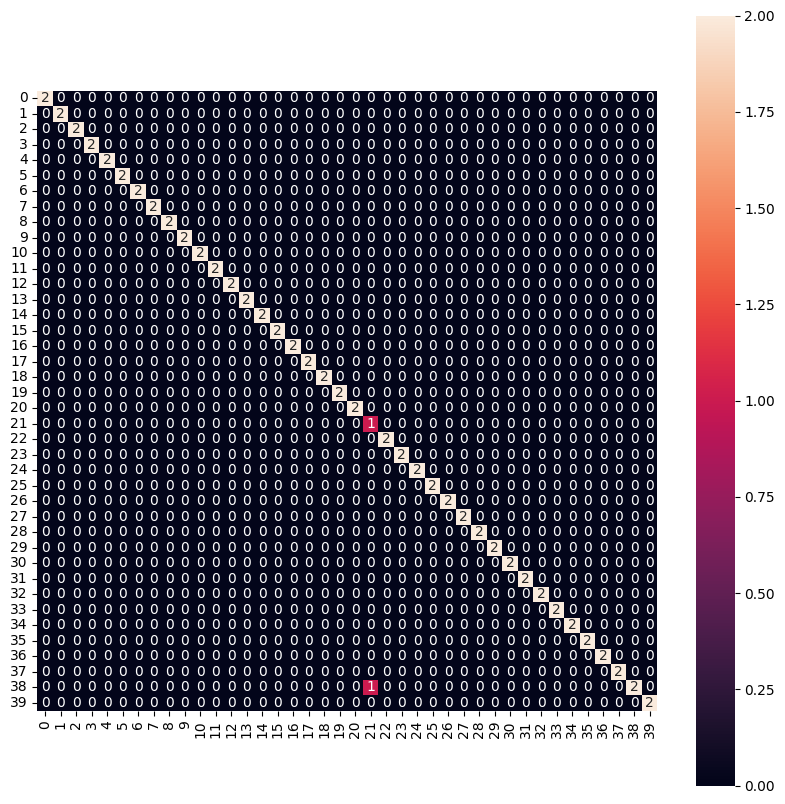

In [22]:
# plot confusion matrix
from sklearn.metrics import confusion_matrix
model_svc.fit(X_train, y_train)
y_pred = model_svc.predict(X_test)
plt.figure(figsize=(10,10))
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=True)

In [23]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data_normalized = scaler.fit_transform(faces.data)

In [24]:
# Using either Agglomerative Hierarchical Clustering (AHC) or Divisive Hierarchical Clustering (DHC) and using
# the centroid-based clustering rule, reduce the dimensionality of the set by using the following similarity measures:
# a) Euclidean Distance [20 points]
# b) Minkowski Distance [20 points]
# c) Cosine Similarity [20 points]

In [25]:

def find_best_n_clusters(metric,data_normalized):
    # Define a range of cluster numbers to try
    cluster_range = range(2, 41)

    # Initialize variables to keep track of best silhouette score and corresponding cluster number
    best_score = -1
    best_n_clusters = None
    best_linkage = None

    # Iterate over the range of cluster numbers
    for n_clusters in cluster_range:
        # Compute pairwise distance matrix
        # pairwise_dist = pairwise_distances(data_normalized, metric)
        
        # Perform Agglomerative Hierarchical Clustering
        if metric == 'euclidean':
            clustering = AgglomerativeClustering(n_clusters=n_clusters, metric= metric, linkage='ward')
            cluster_labels = clustering.fit_predict(data_normalized)
            best_linkage = 'ward'
        else:
            for linkage in ('average', 'complete', 'single'):
                clustering = AgglomerativeClustering(n_clusters=n_clusters, metric= metric, linkage=linkage)
                cluster_labels = clustering.fit_predict(data_normalized)
                
                # Calculate silhouette score
                score = silhouette_score(X=data_normalized,labels=cluster_labels, metric=metric)
                
                # Update best score and corresponding cluster number if needed
                if score > best_score:
                    best_score = score
                    best_n_clusters = n_clusters
                    best_linkage = linkage
                    
        # Calculate silhouette score
        score = silhouette_score(X=data_normalized,labels=cluster_labels, metric=metric)
        
        # Update best score and corresponding cluster number if needed
        if score > best_score:
            best_score = score
            best_n_clusters = n_clusters

    # Print the best number of clusters and its corresponding silhouette score
    print(f"Best number of clusters: {best_n_clusters}")
    print(f"Corresponding silhouette score: {best_score}")
    print(f"Corresponding linkage: {best_linkage}")


In [26]:
find_best_n_clusters('euclidean', data_normalized)

Best number of clusters: 40
Corresponding silhouette score: 0.1697792261838913
Corresponding linkage: ward


In [27]:
find_best_n_clusters('minkowski', data_normalized)

Best number of clusters: 2
Corresponding silhouette score: 0.20152599186223938
Corresponding linkage: average


In [28]:
find_best_n_clusters('cosine', data_normalized)

Best number of clusters: 31
Corresponding silhouette score: 0.24621479213237762
Corresponding linkage: average


In [29]:
euclidean_model = AgglomerativeClustering(n_clusters=40, metric='euclidean', linkage='ward')

In [30]:
euclidean_model.fit(data_normalized)

AgglomerativeClustering(metric='euclidean', n_clusters=40)

In [31]:
# Split the training set, a validation set, and a test set using stratified sampling to ensure that there are the same 
# number of images per person in each set.
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=45)
for train_index, test_index in split.split(faces.data, euclidean_model.labels_):
    X_train_clustered, X_test_clustered = faces.data[train_index], faces.data[test_index]
    y_train_clustered, y_test_clustered = euclidean_model.labels_[train_index], euclidean_model.labels_[test_index]

In [32]:
# train a classifier to predict which person is represented in each picture, using the reduced dimensionality set
# and evaluate it on the validation set.
model = SVC(kernel='linear', C=1)
scores = cross_val_score(model, X_train_clustered, y_train_clustered, cv=5)

c:\SoftwareEng\Diploma\Semester-6\Unsupervised&Reinfo\Assignment3\env\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


In [33]:
scores, scores.mean()

(array([0.984375, 0.96875 , 0.9375  , 0.9375  , 0.953125]), 0.95625)

In [34]:
model.fit(X_train_clustered, y_train_clustered)

SVC(C=1, kernel='linear')

In [35]:
predicted_after_clustering = model.predict(X_test_clustered)

In [38]:
# accuracy on the orginal dataset
accuracy_score(y_test_clustered, predicted_after_clustering)

0.975

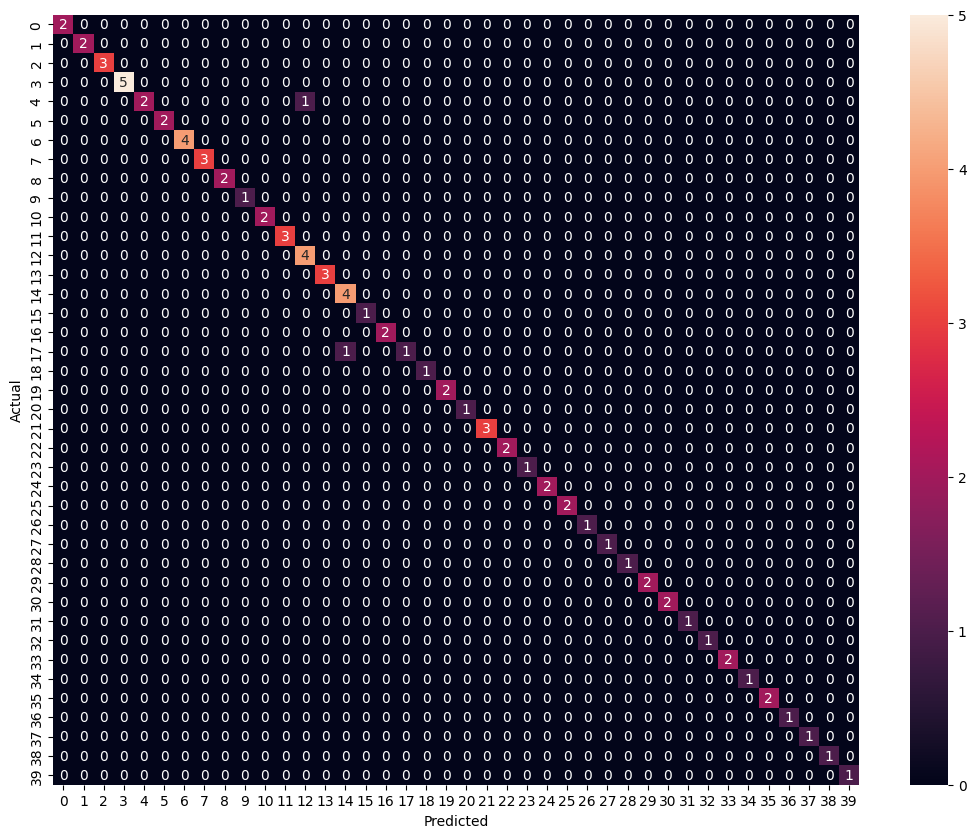

In [39]:
# confusion matrix
from sklearn.metrics import confusion_matrix
plt.figure(figsize=(13,10))
sns.heatmap(confusion_matrix(y_test_clustered, predicted_after_clustering), annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()



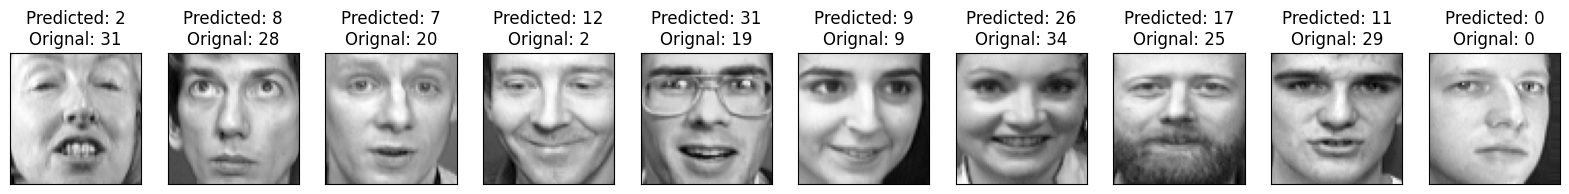

In [60]:
predicted_on_orginal = model.predict(X_test)
# plot image and its predicted label
fig = plt.figure(figsize=(20,20))
for i in range(0, 10):
    ax = fig.add_subplot(1, 10, i+1, xticks=[], yticks=[])
    ax.imshow(X_test[i].reshape(64,64), cmap= 'gray')
    ax.set_title(f"Predicted: {predicted_on_orginal[i]}\nOrignal: {y_test[i]}")
plt.show()


In [61]:
accuracy_score(y_test, predicted_on_orginal)

0.0625